# Байесовские модели: линейная регрессия

## Постановка задачи

In [77]:
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression, SGDRegressor
import scipy.stats as stats
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid', 'ggplot'])

Пусть у нас несть какие-то данные которые можно описать линейной зависимостью $Xw = y$,  
\begin{align*}
    \left\{
            \begin{array}{ll}
                y_1 = w_1 \cdot x_{11} + w_2\cdot x_{12}+ \dots + w_n\cdot x_{1n} \\
                y_2 = w_1\cdot x_{21} + w_2\cdot x_{22}+ \dots + w_n\cdot x_{2n} \\
                \vdots \\
                y_n = w_1\cdot x_{m1} + w_2\cdot x_{m2}+ \dots + w_n\cdot x_{mn}
            \end{array}
        \right. \quad \Rightarrow \quad
        \begin{bmatrix}
            x_{11} & x_{12} & \dots & x_{1n} \\
            x_{21} & x_{22} & \dots & x_{2n} \\
            \vdots & \vdots & \ddots & \vdots \\
            x_{m1} & x_{m2} & \dots & x_{mn}
        \end{bmatrix}
        \begin{bmatrix}
            w_1 \\
            w_2 \\
            \vdots \\
            w_n
        \end{bmatrix} =
        \begin{bmatrix}
            y_1 \\
            y_2 \\
            \vdots \\
            y_m
        \end{bmatrix}
        \quad \Rightarrow \quad
            \vec{x}_1w_1+\vec{x}_2w_2+\dots +\vec{x}_nw_n = \vec{y}
        \quad \Rightarrow \quad
            X\vec{w} = \vec{y}
    \end{align*}  
Где $n$ количество векторов в этих данных, а $m$ количество данных в векторах

Например, $y=2x+1$ можно описать матрицей:
\begin{align*}
    \left\{
        \begin{array}{ll}
            y_1 = w\cdot x_1+b\cdot 1 \\
            y_2 = w\cdot x_2+b\cdot 1 \\
            \vdots \\
            y_n = w\cdot x_n+b\cdot 1
        \end{array}
    \right. \quad \Rightarrow \quad
    \begin{bmatrix}
        x_{1} & 1 \\
        x_{2} & 1 \\
        \vdots & \vdots \\
        x_{m} & 1
    \end{bmatrix}
    \begin{bmatrix}
        w \\
        b
    \end{bmatrix} =
    \begin{bmatrix}
        y_1 \\
        y_2 \\
        \vdots \\
        y_m
    \end{bmatrix}
\end{align*}

Где $w = 2$, а $b=1$.
В данном случае если все данные не содержат шума (ранг дополненной матрицы равен 2), тогда, чтобы получить коэффициенты можно взять любые 2 строки из этой матрицы и решить обычную СЛАУ, например:

\begin{align*}
    \begin{bmatrix}
        x_{1} & 1 \\
        x_{2} & 1
    \end{bmatrix}
    \begin{bmatrix}
        w \\
        b
    \end{bmatrix} =
    \begin{bmatrix}
        y_1 \\
        y_2
    \end{bmatrix}
\end{align*}

Но что если данные зашумлены? То есть $Xw = y+\boldsymbol{\epsilon}$,  где $\boldsymbol{\epsilon}$ случайная величина.

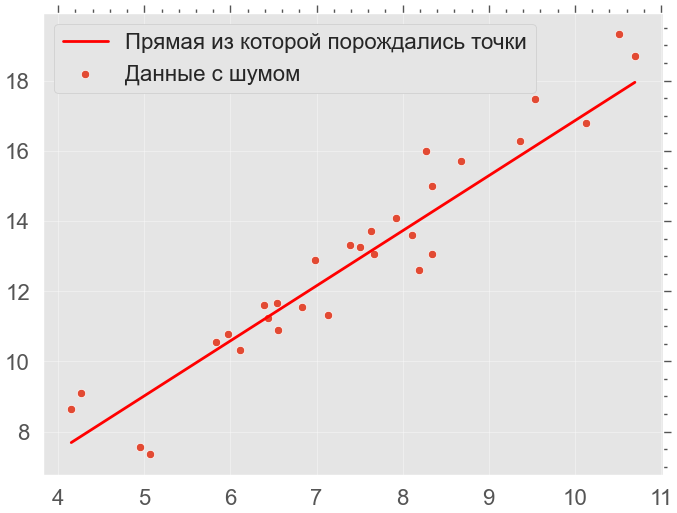

In [374]:
np.random.seed(21)

n = 30
# Создаем двумерный массив x с двумя столбцами: первый столбец - линейное пространство с шумом, второй - единицы
X = np.linspace(5, 10, n).reshape(-1, 1) + np.random.randn(n,1)
X = np.hstack([X, np.ones((n, 1))])

# Генерируем вектор весов w и вектор шума epsilon
w = np.random.randn(2, 1)
epsilon = np.random.randn(n, 1)

# Вычисляем y как линейную комбинацию x и w с добавлением шума epsilon
y = X @ w + epsilon

# Строим прямую из которой порождались точки
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=2, label='Прямая из которой порождались точки')

# Строим точки данных
sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

plt.show()

## Подход выборочного среднего

Решения в явном виде у нас не будет и при решении СЛАУ у нас будут получатся разные прямые. Максимальное количество таких прямых $C_n^2$

In [5]:
# w_array = np.empty((2, n*(n-1)//2))
# k = 0
# 
# sns.scatterplot(x=X[:, 0], y=y[:, 0], color='red', s=100, label='Данные с шумом')
# plt.xlim(plt.xlim())
# plt.ylim(plt.ylim())
# 
# for i in range(n):
#     for j in range(i+1, n):
#         X_step = X[[i, j]]
#         y_step = y[[i, j]]
#         w_step = np.linalg.solve(X_step, y_step)
#         w_array[:,k] = w_step.T
#         k += 1
#         sns.lineplot(x=X[:, 0], y=(X @ w_step)[:, 0], linewidth=0.2)
# 
# sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='Прямая из которой порождались точки')

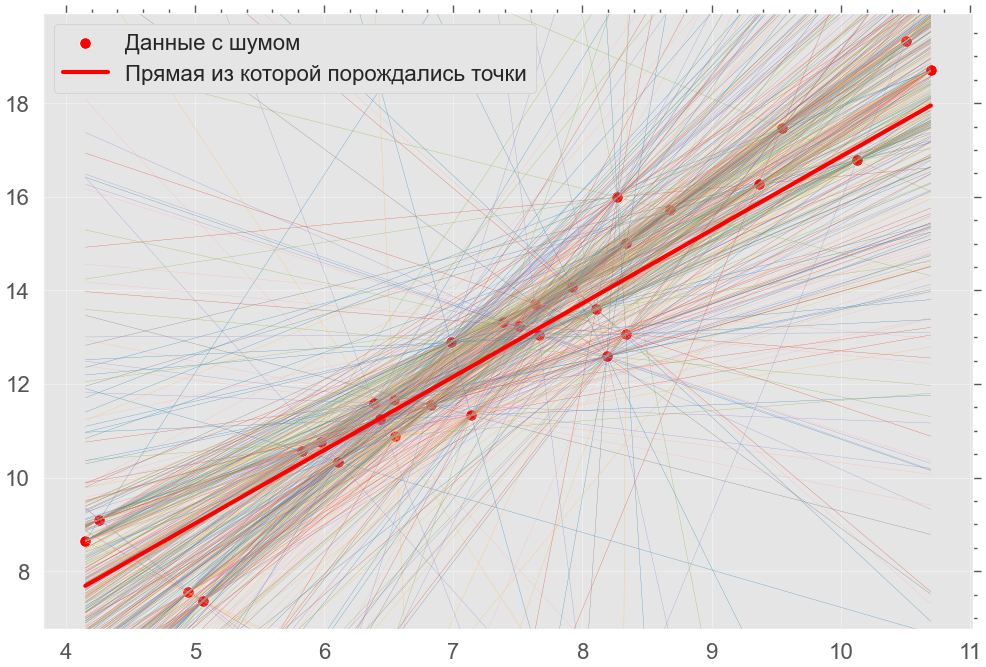

In [60]:
combinations = np.array(np.triu_indices(n, k=1)).T
X_combinations = X[combinations]
y_combinations = y[combinations]

# Решение систем линейных уравнений для каждой пары точек
w_steps = np.linalg.solve(X_combinations[:, :, :2], y_combinations)

# Сохранение результатов в w_array
w_array = w_steps.T

# Построение точек
plt.figure(figsize = (12,8))
sns.scatterplot(x=X[:, 0], y=y[:, 0], color='red', s=70, label='Данные с шумом')

# Установка пределов осей такие же, как у графика точек
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())

# Построение линий для каждого решения
for w_step in w_steps:
    sns.lineplot(x=X[:, 0], y=(X @ w_step)[:, 0], linewidth=0.2)

sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='Прямая из которой порождались точки')

plt.show()

Как видно из графика огромное количество прямых идет мимо нашего тренда, но в целом плотность пучка к нему направленна. 
Давайте попробуем усреднить все веса предполагая что за счет ЦПТ мы получим хорошую оценку реальных значений весов $\mathbf{w}$.

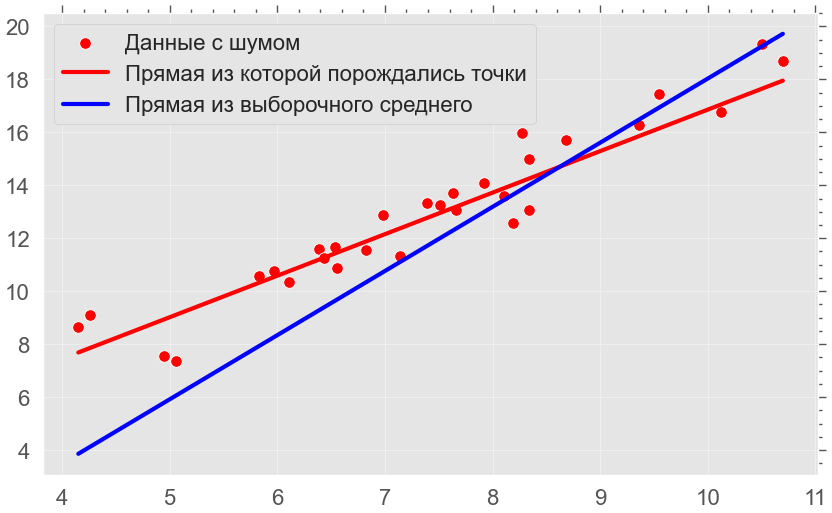

In [4]:
w_mean = np.mean(w_array, axis=2).reshape(-1,1)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:, 0], y=y[:, 0], color='red', s=70, label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='Прямая из которой порождались точки')
sns.lineplot(x=X[:, 0], y=(X @ w_mean)[:, 0], color='blue', linewidth=3, label='Прямая из выборочного среднего')

plt.show()

Как видно из графика наша прямая сильно перекошена в сторону выбросов, давайте попробуем вместо среднего взять медиану, так как она более устойчива к выбросам

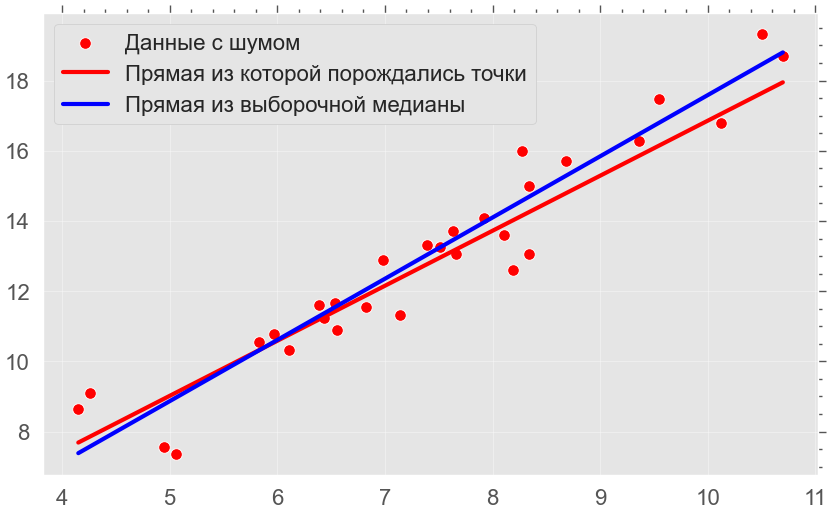

In [5]:
w_median = np.median(w_array, axis=2).reshape(-1,1)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X[:, 0], y=y[:, 0], color='red', s=70, label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='Прямая из которой порождались точки')
sns.lineplot(x=X[:, 0], y=(X @ w_median)[:, 0], color='blue', linewidth=3, label='Прямая из выборочной медианы')

plt.show()

Стало в разы лучше, так как распределение весов имеет очень тяжелые хвосты, из-за прямых построенных на почти вертикальных точках, вообще чудо, что получилась такая хорошая оценка 

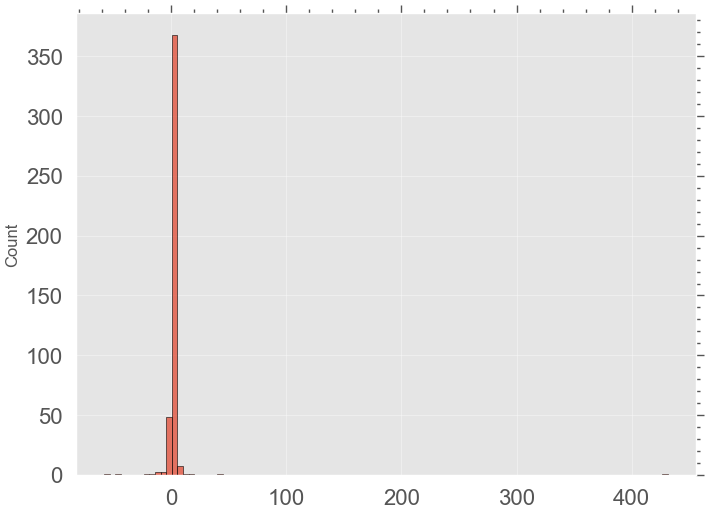

In [15]:
sns.histplot(w_array[0,0],bins=100, edgecolor='black')
plt.show()

В любом случае не сильно хочется решать $O(n^2)$ систем линейных уравнений, чтобы получить хорошую прямую, давайте попробуем найти более эффективный способ 

## Аналитический и геометрический подходы

Поскольку точки порождались какой-то истинной прямой с шумом, можно попробовать найти такую прямую у которой дисперсия данного шума будет минимальной другими словами минимизировать сумму квадратов отклонений от заданной прямой (можно минимизировать модуль отклонений, но об этом поговорим позже)

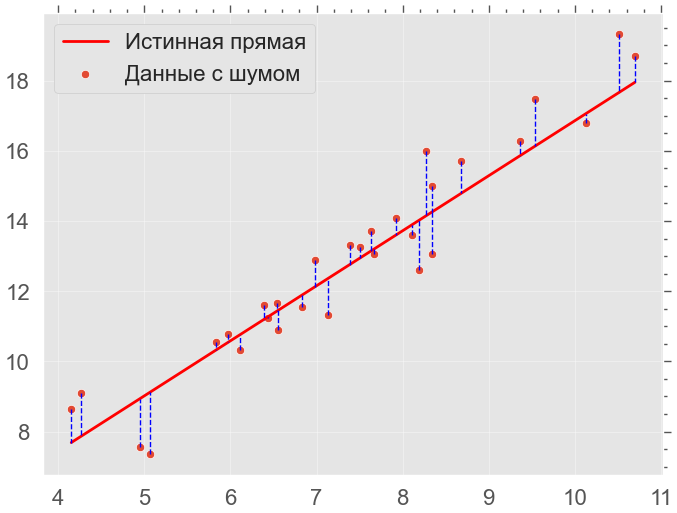

In [6]:
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=2, label='Истинная прямая')
sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

# Вычисляем отклонения и рисуем их
for i in range(n):
    plt.plot([X[i, 0], X[i, 0]], [y[i, 0], (X @ w)[i, 0]], color='blue', linestyle='--', linewidth=1)

plt.show()

На графике мы пытаемся минимизировать длину синих полос. Так как уравнение прямой задается формулой $Xw$ тогда:
$\sum\limits_{i}(x_i^Tw-y_i)^2=\|Xw-y\|^2 \rightarrow min$  
(где $x_i, y_i$ точки данных)  
<br>
$\|Xw-y\|^2 = (Xw-y)^T(Xw-y) = \langle Xw-y, Xw-y\rangle = \langle Xw, Xw\rangle -2 \langle Xw, y\rangle+ \langle y, y\rangle = w^T X^T X w -2w^TX^Ty + y^Ty \rightarrow min$  
<br>
Возьмем градиент по весам прямой $w$ и приравняем его к нулю, чтобы найти минимум:
<br>
$\nabla_w \ (w^T X^T X w -2w^TX^Ty + y^Ty) = 2X^TXw -2X^Ty = 0$
<br>
$X^TXw=X^Ty$
<br>
$w=(X^TX)^{-1}X^Ty$
<br>
Мы вывели явную формулу для нахождения $w$ 

Если мы бы немного знали линейную алгебру, в пространстве $ \mathbb{R}^n $, где $ n $ обозначает количество точек данных, наша оценка $ \hat{y} = Xw $ лежит в линейном подпространстве, порожденном векторами $ x_i $. Минимизация нормы $ \|Xw - y\|^2 $ соответствует минимизации длины вектора ошибки $ \hat{y} - y $, которая достигается, когда вектор ошибки ортогонален гиперплоскости, порожденной векторами $ x_i $, то есть когда $ \hat{y} $ является ортогональной проекцией вектора $ y $ на подпространство, определенное векторами $ x_i $.

![proection](assets/proection.png)

\begin{align*}
    \left\{
        \begin{array}{ll}
            \langle Xw-y, x_1\rangle = 0\\
            \langle Xw-y, x_2\rangle = 0\\
            \vdots \\
            \langle Xw-y, x_m\rangle = 0
        \end{array}
    \right. \quad \Rightarrow \quad
    \langle Xw-y, X\rangle = 0
     \quad \Rightarrow \quad
    $\langle Xw, X\rangle = \langle y, X\rangle$
    \quad \Rightarrow \quad
    X^TXw = X^Ty
    \quad \Rightarrow \quad
    w = (X^TX)^{-1}X^Ty
\end{align*}


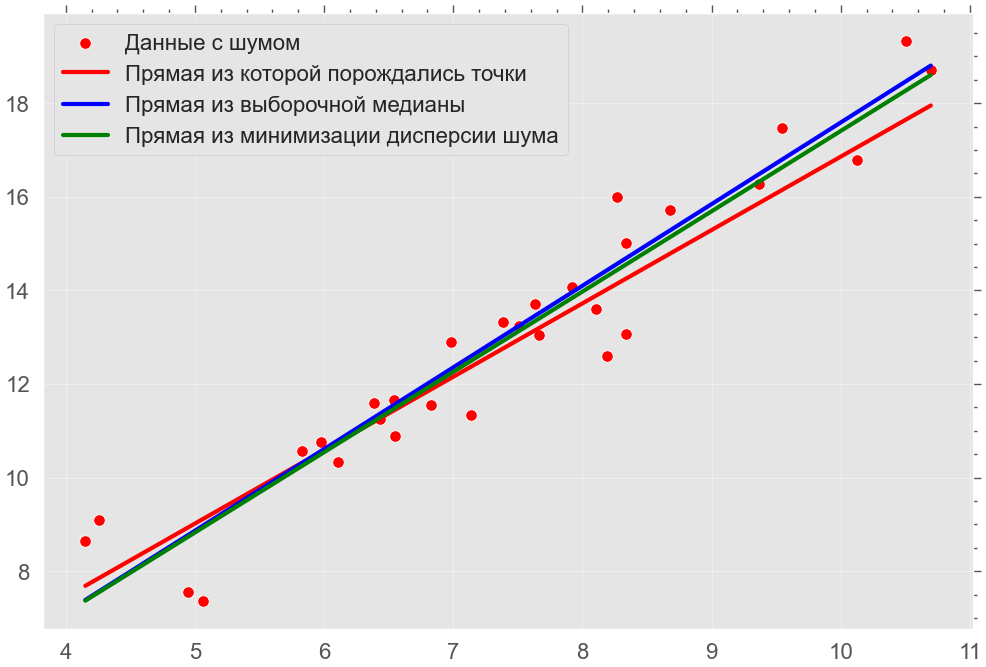

In [378]:
A = X.T@X
w_mse = np.linalg.inv(A)@X.T@y

plt.figure(figsize = (12,8))
sns.scatterplot(x=X[:, 0], y=y[:, 0], color='red', s=70, label='Данные с шумом')
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='Прямая из которой порождались точки')
sns.lineplot(x=X[:, 0], y=(X @ w_median)[:, 0], color='blue', linewidth=3, label='Прямая из выборочной медианы')
sns.lineplot(x=X[:, 0], y=(X @ w_mse)[:, 0], color='green', linewidth=3, label='Прямая из минимизации дисперсии шума')

plt.show()

Матрицу $(X^TX)^{-1}X^T$ иногда называют псевдо-обратной, но ее обычно вычисляют за счет сингулярного разложения (SVD), для которого существует множество алгоритмов быстрого вычисления, и псевдо-обратная матрица спользуя данное разложение вычисляется в разы проще 
<br>
$X = U\Sigma V^T$
<br>
$X^TX = V\Sigma U^TU\Sigma V^T = V\Sigma^2V^T$
<br>
$(X^TX)^{-1} = V\Sigma^{-2}V^T$
<br>
$(X^TX)^{-1}X^T = V\Sigma^{-2}V^T V\Sigma U^T = V\Sigma^{-1}U^T$  

Также в python есть отдельная функция вычисления псевдо-обратной матрицы

In [8]:
U, S, VT = np.linalg.svd(X)
V = VT.T
UT = U.T
S_inv = np.zeros((V.shape[0], UT.shape[0]))
np.fill_diagonal(S_inv, 1/S) 

V@S_inv@UT@y,  w_mse, np.linalg.pinv(X)@y

(array([[1.71596263],
        [0.24644444]]),
 array([[1.71596263],
        [0.24644444]]),
 array([[1.71596263],
        [0.24644444]]))

Также можно найти минимум градиентным спуском

In [10]:
import tensorflow as tf

# Подготовка данных
X_tensor = tf.constant(X, dtype=tf.float32)
y_tensor = tf.constant(y, dtype=tf.float32)

# Модель
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(2,), use_bias=False)
])

# Функция потерь и оптимизатор
model.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

In [13]:
# Обучение модели
model.fit(X_tensor, y_tensor, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 11ms/step - loss: 1.5166
Epoch 2/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.5046
Epoch 3/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.4927
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.4809
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.4692
Epoch 6/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.4577
Epoch 7/1000
1/1 [==============================] - 0s 5ms/step - loss: 1.4463
Epoch 8/1000
1/1 [==============================] - 0s 8ms/step - loss: 1.4350
Epoch 9/1000
1/1 [==============================] - 0s 7ms/step - loss: 1.4239
Epoch 10/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.4129
Epoch 11/1000
1/1 [==============================] - 0s 10ms/step - loss: 1.4020
Epoch 12/1000
1/1 [==============================] - 0s 6ms/step - loss: 1.3912
Epoch 13/1000
1/1 [============================

In [112]:
model.get_weights()

[array([[1.7153324 ],
        [0.25133198]], dtype=float32)]

Но следует понимать что обучение может проходить достаточно медленно

![training](assets/training_0.gif)

Чтобы ускорить обучение можно нормализовать данные.  
(Почему обучение улучшается на нормализованных данных рассмотрим в следующий раз, когда будем исследовать функцию ошибки)

![training](assets/training_1.gif)

## Басовский вывод линейной регрессии

Пусть у нас есть данные $y=f(x)+\epsilon$, где $\epsilon \sim \mathcal{N}(0, \sigma)$, тогда можно сказать что $y \sim \mathcal{N}(f(x), \sigma)$. Если мы предположим что $f(x)$ описывается линейной моделью тогда, $y_i \sim \mathcal{N}(x_i^T \ w, \sigma)$.
Из этого факта наше правдоподобие будет выглядеть как:

$L(w) = P(D|w) = \prod\limits_i P(x_i,y_i|w) = \prod\limits_i \frac{1}{\sigma\sqrt{2 \pi}} EXP\left[\frac{-(y_i - x_i^Tw)^2}{2\sigma^2}\right]$
<br>  
$\ln{L(w)} = \sum\limits_i \left[-\ln{\sigma\sqrt{2 \pi}}-\frac{(y_i - x_i^Tw)^2}{2\sigma^2}\right]$
<br>
Задача максимизации логарифма правдоподобия аналогична задаче минимизации суммы квадратов
 отклонений $\sum\limits_i (y_i - x_i^Tw)^2 = \|(Xw - y) \|^2 \rightarrow min$, которая у нас была при аналитическом подходе.
 
Также можно найти оценку максимального правдоподобия для $\sigma$:

$\frac{n}{\sigma}=\frac{\|(Xw - y) \|^2}{\sigma^3} \Rightarrow \sigma^2 = \frac{\|(Xw - y) \|^2}{n}$

In [326]:
Mean_var = (X@w_mse-y).T@(X@w_mse-y)/n
True_var = np.var(epsilon)

Mean_var, True_var

(array([[0.73607258]]), 0.7975642729483002)

Следует понимать что наша квадратичная функция ошибки возникла из предположения о том что наз шум из нормального распределения, если бы мы предположили что шум порождался из распределения Лапласа $\epsilon \sim \mathcal{Laplace}(0, \sigma)$, тогда наша оценка максимального правдоподобия была бы за счет минимизации суммы модулей отклонений $\sum\limits_i |X_i^T w - y| \rightarrow min$, данная модель менее чувствительная к выбросам

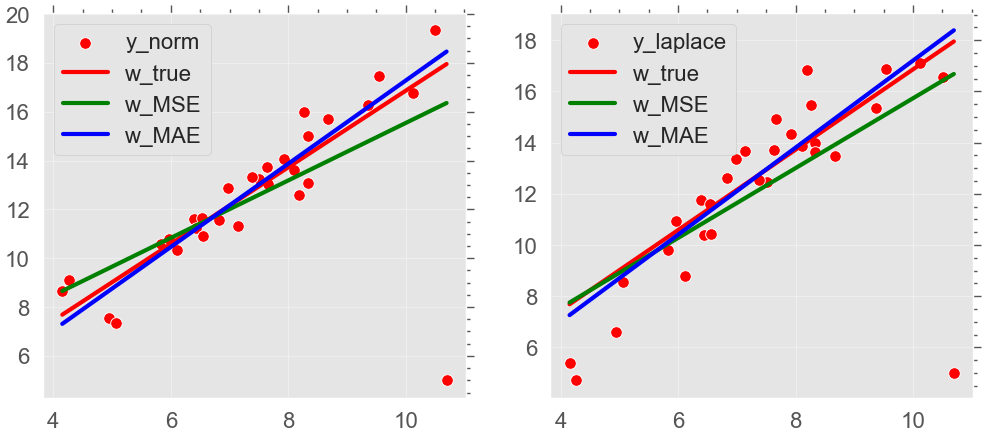

In [377]:
np.random.seed(21)
epsilon_laplace = np.random.laplace(size=(n,1))

y_laplace = X@w+ epsilon_laplace
# Добавление выбросов
y_dump = np.vstack([y[:-1],[5]])
y_laplace[-1] = 5

# Обучение модели на сумме квадратов отклонений
lin_reg = LinearRegression(fit_intercept=False)
sgd_reg = SGDRegressor(loss='epsilon_insensitive', epsilon=0, fit_intercept=False)  # epsilon=0 эквивалентно сумме модулей

w_mse_normal = lin_reg.fit(X, y_dump).coef_.T
w_mae_normal = sgd_reg.fit(X, y_dump.ravel()).coef_.reshape(2,1)
w_mse_laplace = lin_reg.fit(X, y_laplace).coef_.T
w_mae_laplace = sgd_reg.fit(X, y_laplace.ravel()).coef_.reshape(2,1)

_, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=X[:, 0], y=y_dump[:, 0], color='red', s=70, label='y_norm', ax = axs[0])
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='w_true', ax = axs[0])
sns.lineplot(x=X[:, 0], y=(X @ w_mse_normal)[:, 0], color='green', linewidth=3, label='w_MSE', ax = axs[0])
sns.lineplot(x=X[:, 0], y=(X @ w_mae_normal)[:, 0], color='blue', linewidth=3, label='w_MAE', ax = axs[0])

sns.scatterplot(x=X[:, 0], y=y_laplace[:, 0], color='red', s=70, label='y_laplace', ax = axs[1])
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=3, label='w_true', ax = axs[1])
sns.lineplot(x=X[:, 0], y=(X @ w_mse_laplace)[:, 0], color='green', linewidth=3, label='w_MSE', ax = axs[1])
sns.lineplot(x=X[:, 0], y=(X @ w_mae_laplace)[:, 0], color='blue', linewidth=3, label='w_MAE', ax = axs[1])

plt.show()

Но самое главное преимущество байесовского подхода в том что мы можем строить сами распределения наших весов w:
<br>
$P(w|D) = \frac{P(D|w)P(w)}{P(D)}$
<br>
Если брать априорное распределение $P(w)$ как константу тогда (В следующие разы поговорим о случае когд мы берем другое априорное распределение):  
<br>
$P(w|D) \propto P(D|w) \propto \prod\limits_i \frac{1}{\sigma} EXP\left[\frac{-(y_i - x_i^Tw)^2}{2\sigma^2}\right] = \frac{1}{\sigma^n}EXP\left[\sum \limits_i \frac{-(y_i - x_i^Tw)^2}{2\sigma^2}\right] = \frac{1}{\sigma^n}EXP\left[\frac{-\|y - Xw\|^2}{2\sigma^2}\right]$

В итоге $P(w|D)$ является многомерным нормальным распределением

In [379]:
import sympy as sp

w_s = sp.symbols('w')
b_s = sp.symbols('b')
w_vec = sp.Matrix([[w_s], [b_s]])

#Что-бы не считать 100 лет тройной интеграл по страшному выражению который учитывает еще дисперсию, возьмем нашу оценку максимального правдоподобия для дисперсии
P_D_on_w = sp.simplify(sp.exp(-(X@w_vec- y).T@(X@w_vec- y)/2/Mean_var))[0]
P_D_on_w

3.55106680954814e-1556*exp(-20.3784251769176*b**2 - 300.863217221793*b*w + 526.314338088849*b - 1167.61867126373*w**2 + 4081.32609014776*w)

In [380]:
P_D = sp.integrate(P_D_on_w, (w_s, -np.inf, np.inf), (b_s, -np.inf, np.inf)).cancel()
P_w_on_D = P_D_on_w/P_D
P_D

8.96399647167509e-9*pi

Найдем апостериорные распределения для w и b, найдем их среднее и дисперсию

In [381]:
w_dist = sp.integrate(P_w_on_D, (b_s, -np.inf, np.inf)).cancel()
mean_w = sp.integrate(w_s*w_dist, (w_s,-np.inf, np.inf)).cancel()
Var_w = sp.integrate((w_s-mean_w)**2*w_dist, (w_s,-np.inf, np.inf)).cancel()

b_dist = sp.integrate(P_w_on_D, (w_s, -np.inf, np.inf)).cancel()
mean_b = sp.integrate(b_s*b_dist, (b_s,-np.inf, np.inf)).cancel()
Var_b = sp.integrate((b_s-mean_b)**2*b_dist, (b_s,-np.inf, np.inf)).cancel()

print(f"Параметр w: среднее = {mean_w:.3f}, Дисперсия = {Var_w:.3f}")
print(f"Параметр b: среднее = {mean_b:.3f}, Дисперсия = {Var_b:.3f}")

Параметр w: среднее = 1.716, Дисперсия = 0.009
Параметр b: среднее = 0.246, Дисперсия = 0.501


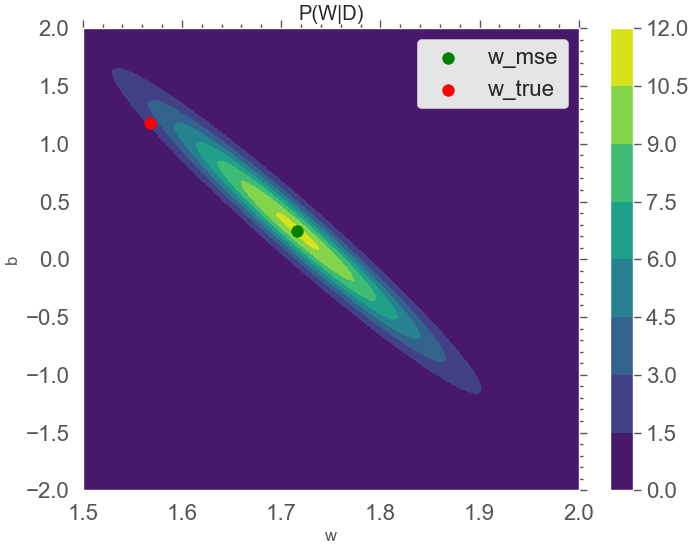

In [427]:
from sympy.utilities.lambdify import lambdify
P_w_on_D_dist_func = lambdify((w_s, b_s), sp.log(P_w_on_D.args[0])+sp.log(P_w_on_D.args[1])+P_w_on_D.args[2].args[0], 'numpy')

# Создаем сетку значений для x и y
w_vals = np.linspace(1.5, 2, 100)
b_vals = np.linspace(-2, 2, 100)
W, B = np.meshgrid(w_vals, b_vals)

# Вычисляем значения совместного распределения на сетке
Z = np.exp(P_w_on_D_dist_func(W, B))

# Визуализация совместного распределения с использованием цветовой карты
plt.figure(figsize=(8, 6))
contour = plt.contourf(W, B, Z, cmap='viridis')
plt.scatter([w_mse[0]], [w_mse[1]], c='g', s=70, label='w_mse')
plt.scatter([w[0]], [w[1]], c='r', s=70, label='w_true')
plt.colorbar(contour)
plt.xlabel('w')
plt.ylabel('b')
plt.title('P(W|D)')
plt.legend()
plt.show()

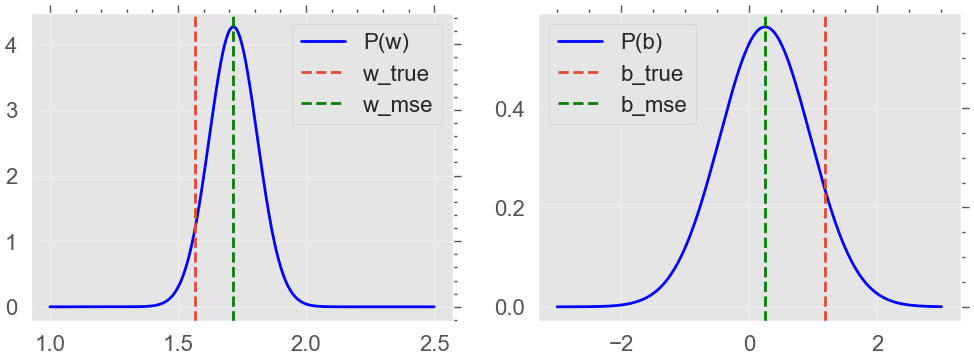

In [452]:
posterior_w_density_func = lambdify(w_s, w_dist, 'numpy')
posterior_b_density_func = lambdify(b_s, b_dist, 'numpy')

w_cords = np.linspace(1,2.5, 1000)
b_cords = np.linspace(-3,3, 1000)
P_w = posterior_w_density_func(w_cords)
P_b = posterior_b_density_func(b_cords)

_, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(w_cords, P_w, color = "b", label="P(w)")
axs[0].axvline(w[0,0], linestyle='--', label= "w_true")
axs[0].axvline(w_mse[0,0], color = "g", linestyle='--',label="w_mse")
axs[1].plot(b_cords, P_b, color = "b", label = "P(b)")
axs[1].axvline(w[1],linestyle='--', label= "b_true")
axs[1].axvline(w_mse[1],color = "g", linestyle='--', label= "b_mse")
axs[0].legend()
axs[1].legend()
plt.show()

In [492]:
x = sp.symbols("x")
w_cdf = sp.integrate(w_dist, (w_s, 0, mean_w.evalf()))
w_cdf.evalf()

3.55712730734447e-73*Integral(exp(196.123390413909*w)*exp(-57.1467543810525*w**2), (w, 0, 1.71596263460619))

In [496]:
print(w_cdf)

6.30484399406387e-73*Integral(exp(196.123390413909*w)*exp(-57.1467543810525*w**2), (w, 0, 1.71596263460619))/sqrt(pi)
